<a href="https://colab.research.google.com/github/KGzB/CAS-Applied-Data-Science/blob/master/Module-2/CAS-D2-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 3, Module 2, Statistical Inference for Data Science, CAS Applied Data Science, 2024-08-28, A. Mühlemann, University of Bern.

*This notebook is based on the notebook by S. Haug and G. Conti from 2020*

# Parameter estimation / regression

**Average expected study time :** 3x45 min (depending on your background)

**Learning outcomes :**

- Know what is meant by parameter estimation and regression
- Calculation of confidence intervals via Python
- Perform linear regression with Python by example
- Perform non-linear regression with Python by example
- Know what non-parametric regression is
- Perform linear regression with Python scikit-learn by example
...

**Main python modules used**
- the Scipy.stat module https://docs.scipy.org/doc/scipy/reference/stats.html
- the Scikit-learn module

If you run this notebook on google colab, you will (probably) have no problems with importing the modules.

**Link to weighted descriptive statistical methods in python**:
https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html

# 3. Inferential Statistics I


Import the Python libraries we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In this notebook, we work with a data set that contains records of river melting dates in the Baltic region.
The data set contains the columns

- *YEAR*: year
- *Riga*: day of year when ice melts in the western Dvina river
- *Bolderaja*: day of year when ice melts in the Bullupe river
- *Parnu*: day of year when ice melts in the Parnu river
- *Tallinn*: day of year of ice break date in Tallinn port
- *Narva*: day of year of ice break in the Narva river
- *St_Petersburg*: day of year of ice break in the Newa river
- *Kronstadt*: day of year of ice break in the gulf of Finland
- *Porvoo*: day of year of ice break in the Porvoonjoki river
- *Turku*: day of year of ice break in the Aura river
- *Pori*: day of year of ice break in the Kokemaenjoki river

Let us first read the data set from Github.

In [4]:
url = "https://github.com/KGzB/CAS-Applied-Data-Science/blob/master/Module-2/baltikum_eisschmelze.csv?raw=true"
df = pd.read_csv(url, sep=";", index_col=0)
df

,Riga,Bolderaja,Parnu,Tallinn,Narva,St_Petersburg,Kronstadt,Porvoo,Turku,Pori
YEAR,,,,,,,,,,
1600,NaN,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN,NaN
1601,113.0,NaN,NaN,143.0,NaN,NaN,NaN,NaN,NaN,NaN
1602,93.0,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,103.0,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,122.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that there are places where we have a lot of missing data. Thus let us first look at the available records.

<Axes: ylabel='YEAR'>

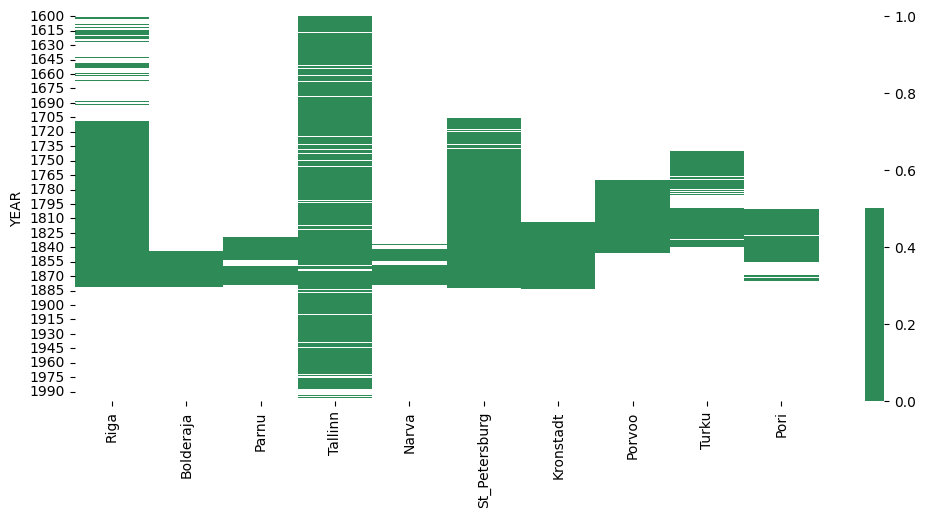

In [5]:
plt.figure(figsize=(12,5))
colours = ['seagreen', 'white']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

We can see that the time series in from Tallinn is the most complete one already starting in 1600.

## 3.1 Model parameter estimation
Let us start with model parameter estimation.
To this end we look at the DOY (day of year) the ice broke up in St_Petersburg.

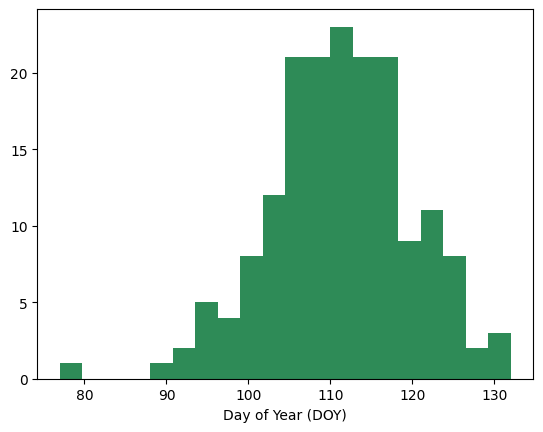

In [15]:
# Histogram of St Petersburg
plt.hist(df['St_Petersburg'], bins=20, color='seagreen')
plt.title("Histogram of Ice Break-up Day in St. Petersburg")
plt.ylabel('Frequency')
plt.xlabel('Day of Year (DOY)')
plt.show()

The histogram suggests that the feature is slightly skewed. But let us nevertheless how well a normal model would fit this feature. Because the mean $\mu$ and the standard deviation $\sigma$ (or variance $\sigma^2$, respectively) completely characterize the form of the normal pdf, we need to estimate the mean and standard deviation from the data.

In [22]:
# Estimation of mean and standard deviation
print('Mean of St_Petersburg:',  df['St_Petersburg'].mean())
print('standard deviation of St_Petersburg:', df['St_Petersburg'].std())

Mean of St_Petersburg: 111.19653179190752
standard deviation of St_Petersburg: 8.672771451259726


Thus, as an estimate for the mean we get 111.20 and 8.67 for the standard deviation. Let us now visually compare the histogram the the estimated normal pdf.

[7.09293971e-05 8.73232906e-05 1.07142110e-04 1.31013658e-04
 1.59661142e-04 1.93913553e-04 2.34716368e-04 2.83142371e-04
 3.40402414e-04 4.07855831e-04 4.87020225e-04 5.79580273e-04
 6.87395162e-04 8.12504219e-04 9.57130280e-04 1.12368029e-03
 1.31474265e-03 1.53308069e-03 1.78162195e-03 2.06344250e-03
 2.38174613e-03 2.73983772e-03 3.14109080e-03 3.58890877e-03
 4.08667992e-03 4.63772621e-03 5.24524607e-03 5.91225156e-03
 6.64150065e-03 7.43542524e-03 8.29605612e-03 9.22494591e-03
 1.02230916e-02 1.12908583e-02 1.24279053e-02 1.36331179e-02
 1.49045451e-02 1.62393461e-02 1.76337479e-02 1.90830151e-02
 2.05814343e-02 2.21223143e-02 2.36980034e-02 2.52999250e-02
 2.69186322e-02 2.85438808e-02 3.01647220e-02 3.17696122e-02
 3.33465399e-02 3.48831679e-02 3.63669883e-02 3.77854877e-02
 3.91263203e-02 4.03774842e-02 4.15274997e-02 4.25655833e-02
 4.34818158e-02 4.42672999e-02 4.49143036e-02 4.54163874e-02
 4.57685104e-02 4.59671151e-02 4.60101867e-02 4.58972876e-02
 4.56295644e-02 4.520972

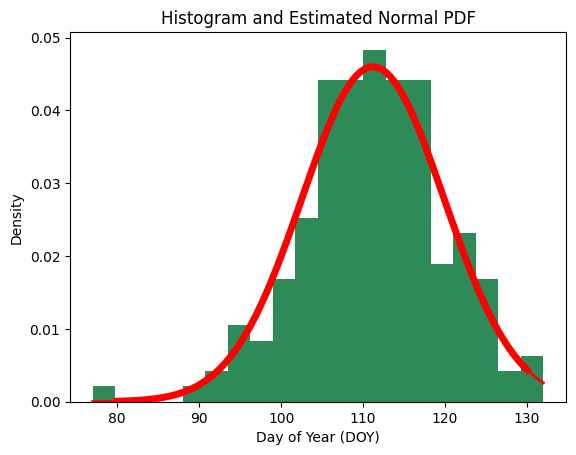

In [32]:
# Create histogram and add the normal pdf with the estimated mean and standard deviation from above
from scipy.stats import norm
plt.hist(df['St_Petersburg'], bins=20, color='seagreen', density=True)
mean = 111.20
std = 8.67
x = np.linspace(df['St_Petersburg'].min(), df['St_Petersburg'].max(), 100)
plt.plot(x, norm.pdf(x, mean, std), color='red', lw=2)

plt.title("'Histogram of DOY with Normal PDF")
plt.ylabel('Day of Year')
plt.xlabel('Density')
#plt.show()
# Calculate the normal pdf based on the estimates above
x = np.linspace(80, 130, 100)
pdf_values = norm.pdf(x, mean, std)
print(pdf_values)

# add the pdf
# Histogram üzerine PDF’yi çiz
plt.plot(x, pdf_values, 'r', linewidth=5)
plt.title('Histogram and Estimated Normal PDF')
plt.xlabel('Day of Year (DOY)')
plt.ylabel('Density')
plt.show()


Looks not too bad, but the left tail is probably a bit too heavy while the right tail is less heavier that for a normal distrubition. Thus, a slightly skewed distribution model would probably suit better. Tomorrow and below we will see more precise options to check normality.

### Example Exponential p.d.f.

This example shall illustrate that even in perfect world where no measurement errors occure, just the fact that we work on a sample rather the whole population does introduce a lot of uncertainty. We now draw a sampe of size 50 from a exponential distribution with $\beta=0.5$ and $\mu=0$, where

the exponential pdf is defined as

$$f(x)=\frac{1}{\beta} e^{-(x-\mu)/\beta}     ,  x \ge \mu;\beta>0$$.

Then from our sample we estimate the scale and location. When you do rerun the code several times you can see that the estimates $\hat{\beta}$ and $\hat{\mu}$ are sometimes quite far from the true values $\beta=0.5$ and $\mu=0$. This uncertainty comes into play by working on a sample. Having measurement errors or more complicated settings increases the uncertainty even more.

 Location = 0.01 , Scale = 0.59


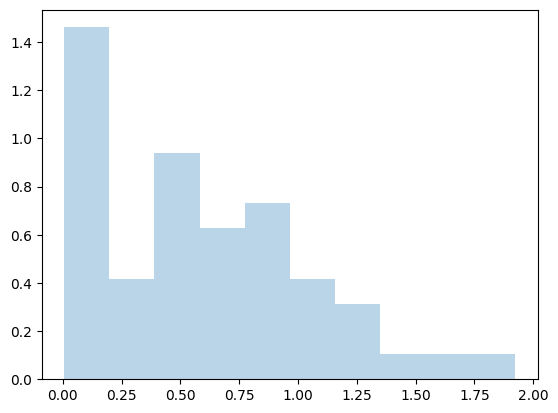

In [33]:
# Let us fit data to an exponential distribution
fig, ax = plt.subplots(1, 1)
# First generate a data set from a exponential distribution
x = stats.expon.rvs(0.0,0.5,size=50) #  scale = 0.5, location = 0.00, 100 variates
ax.hist(x, density=True, histtype='stepfilled', alpha=0.3)
# Fit scale and location to the histogram/data
loc, scale = stats.expon.fit(x) # ML estimator scale, lambda * exp(-lambda * x), scale =1/lambda
print(' Location = %1.2f , Scale = %1.2f' % (loc,scale))
plt.show()

If you run this code serval times, you'll observe that sometimes the estimates for location and scale are rather poor. Here, we know the true underlying distribution but in general we don't. Thus, it would be helpful to know the uncertainties on the fitted values.

## 3.2 Confidence intervall
At the moment we have no clue on how certain we are about point estimates for the mean and standard deviation we calculated above. Hence, it makes sense to additionally look at the confidence intervals.

In [35]:
#95%-t-confidence interval for the mean of St. Petersburg
data = df['St_Petersburg'].dropna().values
n = len(data)
mean = np.mean(data)
std = np.std(data, ddof=1)
alpha = 0.05
t_value = stats.t.ppf(1 - alpha/2, df=n-1)
moe = t_value * (std / np.sqrt(n))
ci_lower = mean - moe
ci_upper = mean + moe

print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"95% t-confidence interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Mean: 111.20
Standard deviation: 8.67
95% t-confidence interval: (109.90, 112.50)


Unfortunately, there is no Python library that computes the confidence interval of standard deviation, so we have to do it "by hand".

In [36]:
# confidence intervall for the standard deviation of normally distributed data
alpha = 0.05  # significance level = 5%
n = len(df['St_Petersburg'])  # sample sizes
s2 = np.var(df['St_Petersburg'], ddof=1)   # sample variance
degf = n - 1                 # degrees of freedom

upper = np.sqrt((n - 1) * s2 / stats.chi2.ppf(alpha / 2, degf))
lower = np.sqrt((n - 1) * s2 / stats.chi2.ppf(1 - alpha / 2, degf))
(lower, upper)

(np.float64(8.110535343847783), np.float64(9.319405079522214))

Interpret the confidence intervals!

You can find more on confidence intervals under https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#chi_square - I found this Link quite helpful :)

## 3.1 About linear Regression

Simple linear regression means fitting a straight line to data a set of points $(x,y)$. A line is described as

$$y = ax + b$$

Thus, two parameters $a$ (slope) and $b$ (intersection with y axis) are fitted.

There are different fitting methods, mostly least squares or maximum likelihood are used.


### Linear regression in Python

When we look at the available data from Riga and Bolderaja, we see that there is a lot less measurements from Bolderaja. It would, however, be nice if we could reconstruct the missing measurement from Bolderaja by using our observations from Riga. Before we go ahead, we should probably check whether this is reasonable. Let us thus compare the two line plots.

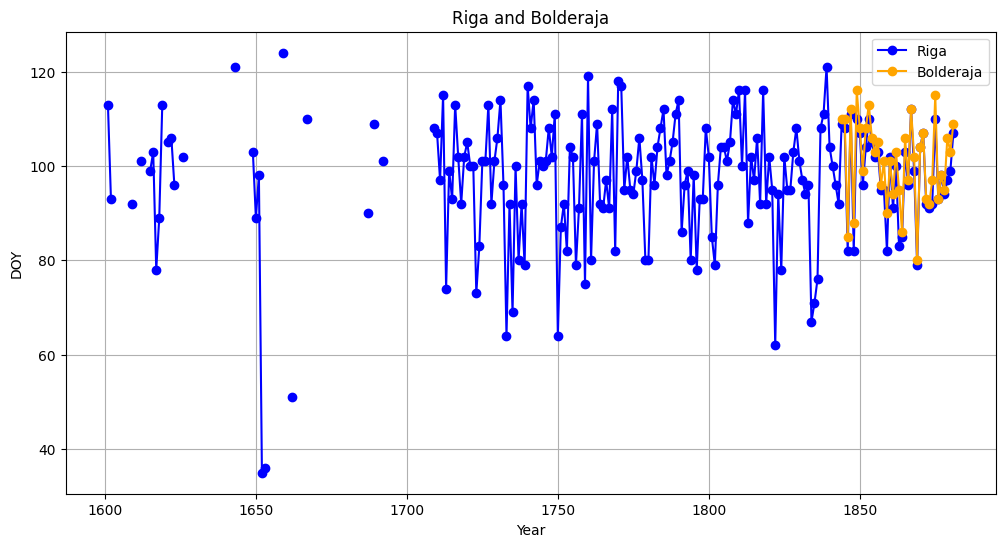

In [37]:
df = df.reset_index()
plt.figure(figsize=(12, 6))

# Plot Riga
plt.plot(df['YEAR'], df['Riga'], marker='o', label='Riga', color='blue')

# Plot Bolderaja
plt.plot(df['YEAR'], df['Bolderaja'], marker='o', label='Bolderaja', color='orange')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('DOY')
plt.title('Riga and Bolderaja')
plt.legend()
plt.grid(True)


plt.show()

There seems to indeed exist a relationship between the DOY the ice melts in Riga and Bolderaja. Thus, let us now try to estimate the missing data by using a simple linear regression model.

We use https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html, using least squares.

In [38]:
import statsmodels.api as sm

# Run an OLS Regression and look at the results

Under *coef* we can see the estimates for $a$ and $b$. *P>|t|* corresponds to the p-value for the test with working hypothesis that the respective estimate ($\hat{a}, \hat{b}$) not equals 0. *Prob (F-statistic)* is the p-value for the test with working hypothesis, that at least one explanatory variable has a significant effect on the outcome. *R-squared* describes how well the variance in the data is explained by the model (1 = everything, 0 = nothing). One Problem with *R-squared* is that its value increases with the number of explanatory variables. Thus, often it makes more sense to look at *Adj. R-squared* which is corrected for the number of explanatory variables.

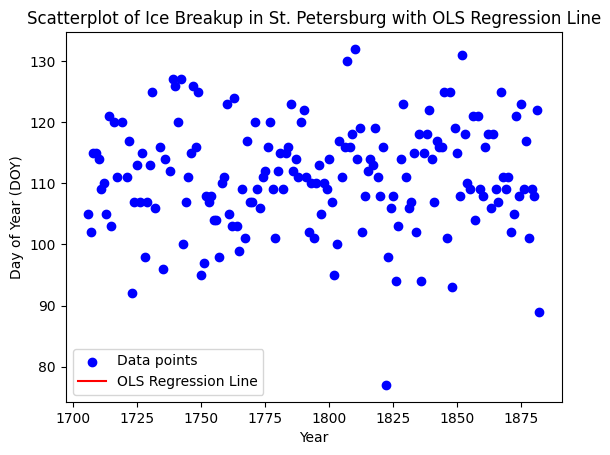

                            OLS Regression Results                            
Dep. Variable:          St_Petersburg   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Aug 2025   Prob (F-statistic):                nan
Time:                        22:51:02   Log-Likelihood:                    nan
No. Observations:                 400   AIC:                               nan
Df Residuals:                     398   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

In [40]:
# Draw Scatterplot and add model
# Bağımsız ve bağımlı değişken
X = df['YEAR']
y = df['St_Petersburg']

# Sabit (intercept) ekle
X_const = sm.add_constant(X)

# OLS modeli oluştur ve fit et
model = sm.OLS(y, X_const)
results = model.fit()

# Katsayıları al
intercept, slope = results.params

# Scatter plot
plt.scatter(X, y, color='blue', label='Data points')

# Regresyon çizgisi
plt.plot(X, intercept + slope*X, color='red', label='OLS Regression Line')

plt.xlabel('Year')
plt.ylabel('Day of Year (DOY)')
plt.title('Scatterplot of Ice Breakup in St. Petersburg with OLS Regression Line')
plt.legend()
plt.show()

# Sonuçları yazdır
print(results.summary())

Let us now look at the reconstructed time series in Bolderaja.

In [ ]:
# Make predictions for Bolderaja and plot the results


Let us look more closely the area, where we know the true ice melt times in Bolderaja.

In [ ]:
# Zoom in to plt.xlim(1840, 1882) where we also have the true observations of Bolderaja and add these to the plot as well

What do you think?

### Diagnostics
Credits to https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/ for implementing the diagnostic plots! This reference also helps with interpretation of those plots!

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use("seaborn-v0_8") # pretty matplotlib plots

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]
  tmp = pd.concat([model_fitted_y, model_residuals], axis=1, keys=['fitted', 'residuals'])


  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(data=tmp, x='fitted', y='residuals',
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  tmp2 = pd.DataFrame(model_norm_residuals_abs_sqrt, columns = ['model_norm_residuals_abs_sqrt'])
  tmp3 = pd.concat([model_fitted_y, tmp2], axis=1, keys=['fitted', 'residuals_normed'])
  sns.regplot(data=tmp3, x='fitted', y='residuals_normed',
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  tmp4 = pd.DataFrame(model_leverage, columns = ['model_leverage'])
  tmp5 = pd.DataFrame(model_norm_residuals, columns = ['model_norm_residuals'])
  tmp6 = pd.concat([tmp4, tmp5], axis=1, keys=['leverage', 'residuals_normed'])
  sns.regplot(data=tmp6, x='leverage', y='residuals_normed',
             scatter=False,
             ci=False,
             lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:87: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3637992682.py:87: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


In [ ]:
# run diagnostics

Look at the reference and think about the assumptions of the ols regression. Are they fulfilled?

## 3.2 More on regression
### 3.2.1 Non-linear regression

If a line is not straight it is curved. There are many mathematical functions whose parameters we can try to fit to experimental data points. Some examples: Polynominals (first order is linear regression, second order is a parabola etc), exponential functions, normal function, sindoial wave function etc. You need to choose an approriate shape/function to obtain a good result.

With the Scipy.stat module we can look for preprogrammed functions (in principle you can program your own function whose parameters you want to fit too): https://docs.scipy.org/doc/scipy/reference/stats.html.

The scipy.optimize module provides a more general non-linear least squares fit. Look at and play with this example. It is complex and you will probably use some time to fully understand every step.

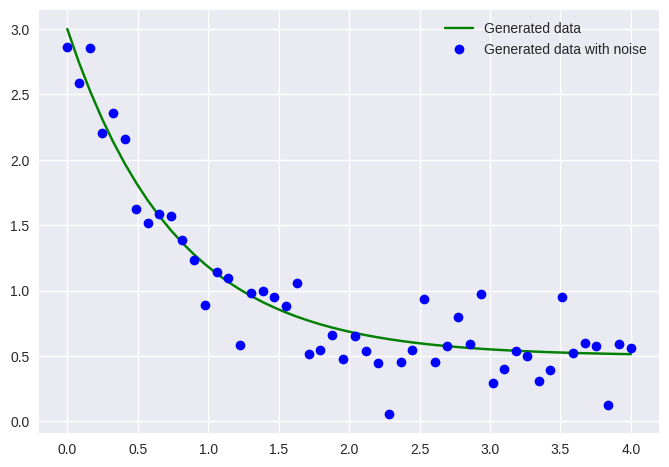

In [42]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
     return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50) #
y = func(xdata, 2.5, 1.3, 0.5)
plt.plot(xdata, y, 'g-', label='Generated data')
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'bo', label='Generated data with noise')
plt.legend()
plt.show()

Let's fit the curve.

[2.55423706 1.35190946 0.47450617]


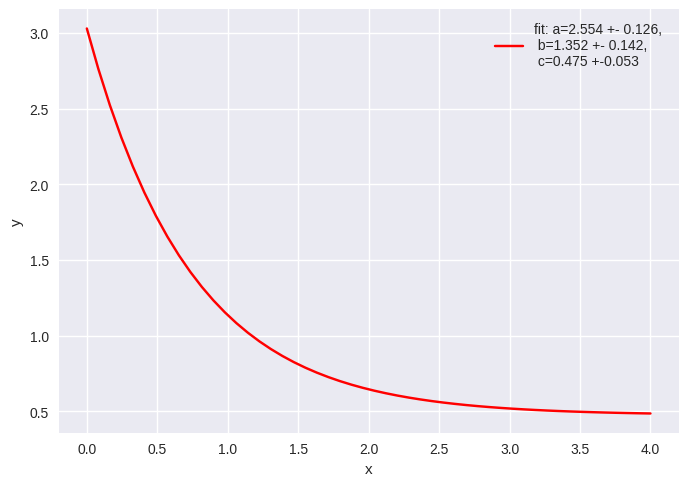

array([0.12605755, 0.14212384, 0.05315968])

In [43]:
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)
perr = np.sqrt(np.diag(pcov)) # Standard deviation = square root of the variance being on the diagonal of the covariance matrix
plt.plot(xdata, func(xdata, *popt), 'r-',label= \
         'fit: a=%5.3f +- %5.3f, \n b=%5.3f +- %5.3f, \n c=%5.3f +-%5.3f' % \
         (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# pcov is the covariance matrix. The errors**2 of each parameter are the values on the diagonal.
perr = np.sqrt(np.diag(pcov)) # Standard deviation = square root of the variance being on the diagonal of the covariance matrix
perr


Compare it to the data and the true function.

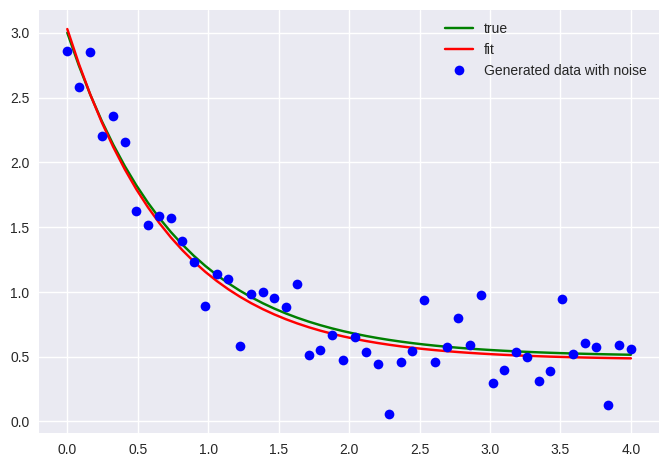

In [44]:
plt.plot(xdata, y, 'g-', label='true')
plt.plot(xdata, func(xdata, *popt), 'r-',label= 'fit')
plt.plot(xdata, ydata, 'bo', label='Generated data with noise')
plt.legend()
plt.show()

Try to add a bit noise and rerun the code.

### 3.2.2 Non-parametric regression

So far we have used functions (models) with some predefined model. The parameters we fitted to data. If we have no clue about the model, but a rought idea on the shape non-parametric methods like isotonic regression. However, these require more data as also the exact shape needs to guessed or fitted from the data. So normally a non-parametric method gives poorer results.

There are several ways to do this in Python. You make look at this if you are interested:

https://pythonhosted.org/PyQt-Fit/NonParam_tut.html

### 3.2.3 Fitting with scikit-learn

When it comes to machine learning, the `scikit-learn` module is much richer than the stats module. You can find extensive documentation with examples in the [user guide](https://scikit-learn.org/stable/user_guide.html)

The module contains A LOT of different machine learning methods, and here we will cover only few of them. What is great about `scikit-learn` is that it has a uniform and consistent interface.

All the different ML approaches are implemented as classes with a set of same main methods:

1. `fitter = ...`: Create object.
2. `fitter.fit(x, y[, sample_weight])`: Fit model.
3. `y_pred = fitter.predict(X)`: Predict using the model.
4. `s = fitter.score(x, y[, sample_weight])`: Return an appropriate measure of model performance.

This allows us to easily replace one approach with another and find the best one for the problem at hand, by simply using another regression/classification object, while the rest of the code can remain the same.

*But you should be careful that there remains some justification! Otherwise you'll overfit. To be sure, you should use an approach like cross validation.*

In [45]:
# Let's write a method which can generate a linear dataset
# with n_d dimensions and some gaussian noise to it
import numpy as np
import matplotlib.pyplot as plt

def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true w =', w, ';  b =', b)

  return x, y

true w = [6.62037466] ;  b = 5.358388323474408


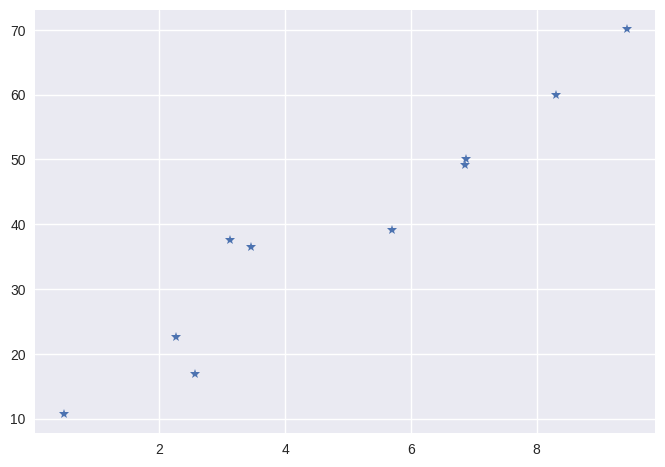

In [46]:
# Sample data from a straight line with noise to it
x, y = get_linear(n_d=1, n_points=10)
plt.plot(x[:, 0], y, '*')

In [47]:
from sklearn import datasets, linear_model
reg = linear_model.LinearRegression()
reg.fit(x, y)

LinearRegression()

In [48]:
w, w0 = reg.coef_, reg.intercept_
print(w, w0)

[6.17760321] 8.949962685639782


scikit-learn does not support calculation of covariance on fitted parameters. That is a pity maybe. However, we can use numpy vectorized methods.


In [49]:
np.std(y - reg.predict(x))

np.float64(4.803242438678297)

In [50]:
(np.cov(y - reg.predict(x)))**0.5

np.float64(5.063062086735022)

What about ```.score()```?



In [51]:
from sklearn.metrics import mean_squared_error, r2_score
# For regression the .score() yields the coefficient of determination.
print('Score: %.2f'
      % reg.score(x, y))
# Indeed, when calculating r2 "by hand" we end up with the same result.
print('Coefficient of determination: %.2f'
      % r2_score(y, reg.predict(x)))



Score: 0.93
Coefficient of determination: 0.93


What the default of ```.score()``` is can be found in each estimator’s documentation. If you like to choose your scoring function yourself, you can find the implemented versions under this link https://scikit-learn.org/stable/modules/model_evaluation.html.

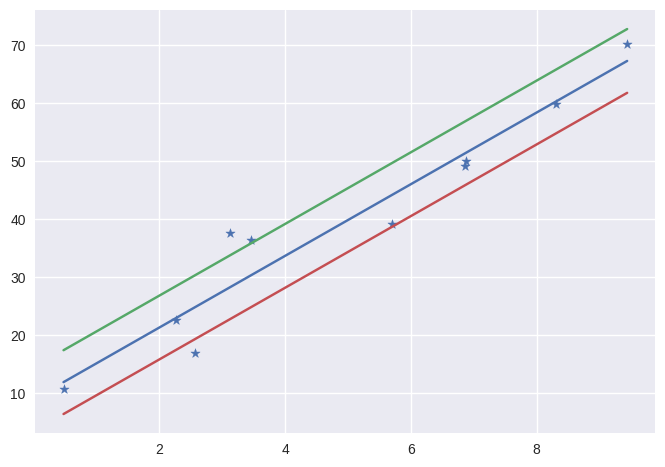

In [52]:
# Plot the fitted model with plus minus one standard deviation.
# Are the data points distributed as expected?
plt.scatter(x, y, marker='*')
x_f = np.linspace(x.min(), x.max(), 10)
y_f = w0 + w[0] * x_f
plt.plot(x_f, y_f)
plt.plot(x_f, y_f+5.5)
plt.plot(x_f, y_f-5.5)

true w = [1.77712535 8.16584955] ;  b = 4.638400487685367


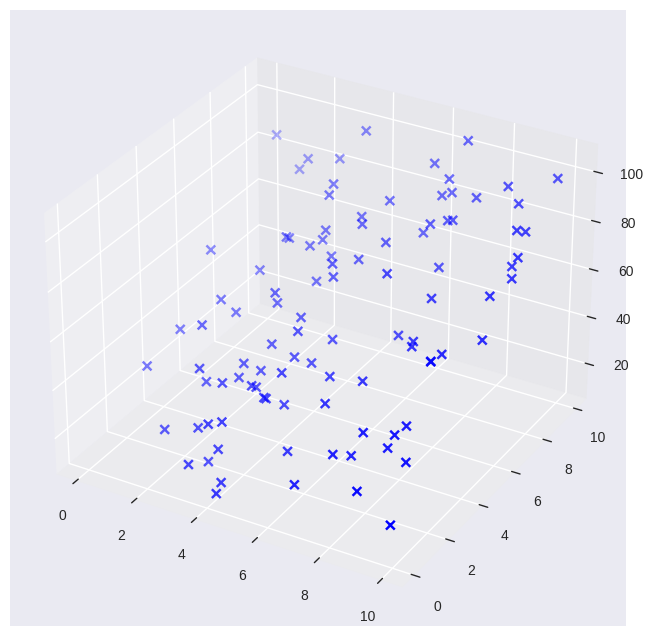

In [53]:
# Generate data points from a plane with some noise to it (default)
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x, y)

true w = [4.29092181 5.71695138] ;  b = -5.959560350076563


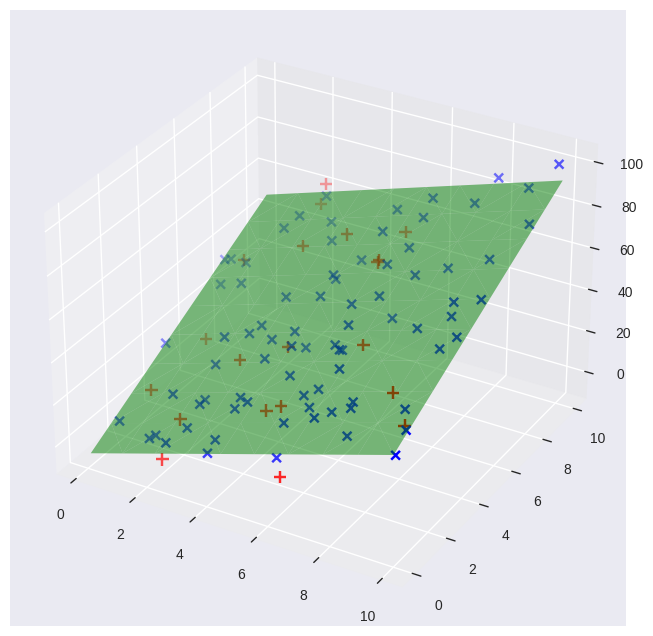

In [54]:
# When doing ML, it is recommended to split the dataset into a training
# and a test set. The training set is used to learn the parameters. The
# test set can be used to assess the performance of the trained model
# (overfitting and underfitting). sklearn provides a helpful method doing that.

from sklearn.model_selection import train_test_split

n_d = 2
x, y = get_linear(n_d=n_d, n_points=100, sigma=5)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, marker='x', color='b',s=40)
ax.scatter(x_test[:,0], x_test[:,1], y_test, marker='+', color='r',s=80)

xx0 = np.linspace(x[:,0].min(), x[:,0].max(), 10)
xx1 = np.linspace(x[:,1].min(), x[:,1].max(), 10)
xx0, xx1 = [a.flatten() for a in np.meshgrid(xx0, xx1)]
xx = np.stack((xx0, xx1), axis=-1)
yy = reg.predict(xx)
ax.plot_trisurf(xx0, xx1, yy, alpha=0.5, color='g');

In [55]:
print('Score: %.2f'
      % reg.score(x, y))
print('Standard deviation of error: %.2f'
      % np.std(y-reg.predict(x)))

Score: 0.94
Standard deviation of error: 4.96


### 3.2.4 - Much used ML performance measures

1. Regression:
* Mean Square Error (MSE): $mse=\frac{1}{n}\sum_i(y_i - \hat y(\bar x_i))^2$
* Mean Absolute Error (MAE): $mae=\frac{1}{n}\sum_i|y_i - \hat y(\bar x_i)|$
* Median Absolute Deviation (MAD): $mad=median(|y_i - \hat y(\bar x_i)|)$
* Fraction of the explained variance: $R^2=1-\frac{\sum_i(y_i - \hat y(\bar x_i))^2}{\sum_i(y_i - \bar y_i)^2}$, where $\bar y=\frac{1}{n}\sum_i y_i$


### 3.2.5 Multiple Linear Regression

In [60]:
url = "https://raw.githubusercontent.com/krishnaik06/Multiple-Linear-Regression/master/50_Startups.csv"
ds = pd.read_csv(url)
print(ds.head())
print(ds.shape)



   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94
(50, 5)


In [61]:
#Convert the 'States' into categorical columns
states=pd.get_dummies(ds['State'],drop_first=True)

# Convert boolean dummy variables to integers
states = states.astype(int)

# X explanatory variables, Y response
X = ds[['R&D Spend','Administration','Marketing Spend']]
X = pd.concat([X,states],axis=1)
Y = ds['Profit']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Create and fit the OLS model on training data
model = sm.OLS(Y_train, X_train)
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           3.91e-21
Time:                        23:06:07   Log-Likelihood:                -421.10
No. Observations:                  40   AIC:                             854.2
Df Residuals:                      34   BIC:                             864.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.255e+04   8358.538     

Evaluate other scores:

In [62]:
#evaluate MSE, MAD, and R2 on train and test datasets
#prediction in sample:
y_p_train = results.predict(X_train)

# Predicting the Test set results
X_test = sm.add_constant(X_test)
y_p_test = results.predict(X_test)

# mse
print('train mse =', np.std(Y_train - y_p_train))
print('test mse =', np.std(Y_test - y_p_test))
# mae
print('train mae =', np.mean(np.abs(Y_train - y_p_train)))
print('test mae =', np.mean(np.abs(Y_test - y_p_test)))

train mse = 9031.666612578969
test mse = 8239.203787443497
train mae = 6341.535758318905
test mae = 7514.293659513181


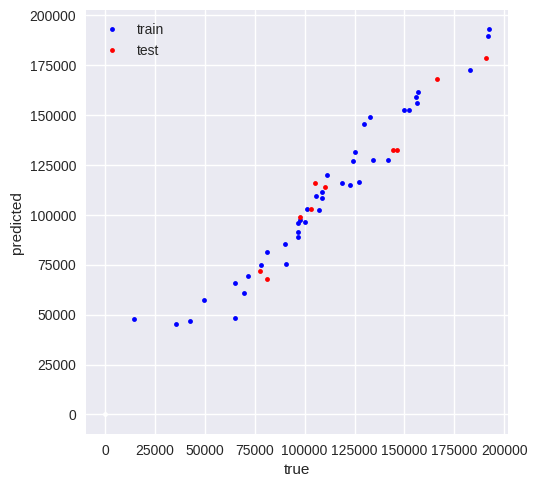

In [63]:
# plot y vs predicted y for test and train parts
plt.plot(Y_train, y_p_train, 'b.', label='train')
plt.plot(Y_test, y_p_test, 'r.', label='test')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()

## Questions

We have now seen how to calculate confidence intervals and do linear regression with several python modules. The most popular ML models are implemented in sklearn. We don't have time practicing them in this Module. In Module 3 we will learn and practice deep neural networks.

Please post a question about today's content here:
https://forms.gle/ZY4pbMiEu1iYFYbp7

Many thanks and see you tomorrow!
